In [46]:
import torch
import numpy as np

## BatchEnsemble
Below you find a PyTorch implementation of Wen et al.'s paper *"BatchEnsemble: An Alternative Approach to Efficient Ensemble and Lifelong Learning"*.  
There are some options available of how to initialize the weights, there is also an option whether to use *'expand'* functionality or not.  
We have utilized expand for memory efficiency, for the interested reader, have a look at PyTorch's documentation [expand](https://pytorch.org/docs/stable/generated/torch.Tensor.expand.html).  
We will provide two demonstrations, one with expand functionality and one without. 

### With Expand Functionality

In [47]:
from utils.layers import BatchLinear
# Define initialization values
ensemble_size = 8 # Number of ensemble members in the NN ensemble
input_shape = 2 # Number of features in the data 
hidden_units = 256 # Number of hidden units
output_shape = 1

# Create a shallow ensemble
shallow_ensemble = torch.nn.Sequential(
    BatchLinear(ensemble_size=ensemble_size,
                in_features=input_shape,
                out_features=hidden_units,
                ),
    torch.nn.ReLU(),
    BatchLinear(ensemble_size=ensemble_size,
                in_features=hidden_units,
                out_features=output_shape,
                )
)

# Initialize a tensor with random data
input = torch.randn(size=(10,input_shape))

# Make inference
# We unsqueeze the input such that the input into the model is of size 
#(N, ensemble_size, input_shape)
result = shallow_ensemble(input.unsqueeze(1).expand(-1, ensemble_size, -1))

print(f"The resulting tensor shape: {result.shape}, it provides a tensor with the following dimensions (N, ensemble_size, output_shape)")


The resulting tensor shape: torch.Size([10, 8, 1]), it provides a tensor with the following dimensions (N, ensemble_size, output_shape)


### Without expand functionality

In [39]:
# Define initialization values
ensemble_size = 8 # Number of ensemble members in the NN ensemble
input_shape = 2 # Number of features in the data 
hidden_units = 256 # Number of hidden units
output_shape = 1

# Create a shallow ensemble
shallow_ensemble = torch.nn.Sequential(
    BatchLinear(ensemble_size=ensemble_size,
                in_features=input_shape,
                out_features=hidden_units,
                expand=False
                ),
    torch.nn.ReLU(),
    BatchLinear(ensemble_size=ensemble_size,
                in_features=hidden_units,
                out_features=output_shape,
                expand=False
                )
)

# Initialize a tensor with random data
N = 10 # Number of data points
input = torch.randn(size=(N,input_shape))

# Make inference
# We repeat the input such that each ensemble can utilize the data, the ingoing tensor will be of shape
# (N*ensemble_size, input_shape)
result = shallow_ensemble(input.repeat(ensemble_size, 1))
print(f"The resulting tensor shape: {result.shape}, it provides a tensor with the following dimensions (N*ensemble_size, output_shape)")

# Retrieve each ensemble member's predictions
results = result.reshape(ensemble_size, N)
print(f"The results for each ensemble member:{results.shape} (ensemble_size X predictions)")

The resulting tensor shape: torch.Size([80, 1]), it provides a tensor with the following dimensions (N*ensemble_size, output_shape)
The results for each ensemble member:torch.Size([8, 10]) (ensemble_size X predictions)


## AnchoredBatchEnsemble
Below you find our proposed method, it combines both Anchored regularization introduced by Pearce et al. in [Uncertainty in Neural Networks: Approximately Bayesian Ensembling](https://proceedings.mlr.press/v108/pearce20a.html) and the scalability improvements from [BatchEnsemble](https://arxiv.org/abs/2002.06715) proposed by Wen et al.  
Furthermore, we utilize an architecture which allows us to predict mean and variances, we achieve this by utilizing a mean and variance layer on top of our feed-forward network.  
If you wish to create a model which solely provides point predictions you can simply use the class *'AnchoredBatch'* from the layers.py file.  
Here, we will show how to train the model such that you are able to regularize the model with the anchors.

In [2]:
# Import the model and a training function
from utils.models import AnchoredBatchEnsemble
from utils.functions import train_models_w_mean_var

In [20]:
# Load toy dataset
data = np.load(r"data\toy_data.npy")

x, y = data[:, 0], data[:, 1]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dataset = torch.utils.data.TensorDataset(torch.from_numpy(x.astype(np.float32)).reshape(-1, 1).to(device), 
                                         torch.from_numpy(y.astype(np.float32)).reshape(-1, 1).to(device))

# Split the dataset
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [int(0.8 * len(dataset)), len(dataset) - int(0.8 * len(dataset))])

# Define the DataLoaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=True)

In [39]:
# Define hyperparameters
ensemble_size = 8
hidden_units = 256
hidden_layers = 4
data_noise = 0.005

# Training parameters
epochs=1000
loss_fn = torch.nn.GaussianNLLLoss()
optimizer = torch.optim.Adam 

# Initiate model
model = AnchoredBatchEnsemble(ensemble_size=ensemble_size, hidden_layers=hidden_layers, hidden_units=hidden_units,input_shape=1)

# Train the model
train_models_w_mean_var(
    model = model,
    ensemble_type = 'anchored_batch',
    ensemble_size = ensemble_size,
    data_noise = data_noise,
    epochs=epochs,
    print_frequency=100,
    loss_fn=loss_fn,
    optimizer=optimizer,
    train_loader=train_loader,
    test_loader=test_loader
)

Epoch: 0
-------
Train Loss: 123.85733795166016
Epoch: 100
-------
Train Loss: -4.958080768585205
Epoch: 200
-------
Train Loss: -5.4350186586380005
Epoch: 300
-------
Train Loss: -6.839589357376099
Epoch: 400
-------
Train Loss: -5.7624019384384155
Epoch: 500
-------
Train Loss: -7.110257387161255
Epoch: 600
-------
Train Loss: -7.2713258266448975
Epoch: 700
-------
Train Loss: -6.805726766586304
Epoch: 800
-------
Train Loss: -7.294496536254883
Epoch: 900
-------
Train Loss: -6.997917175292969


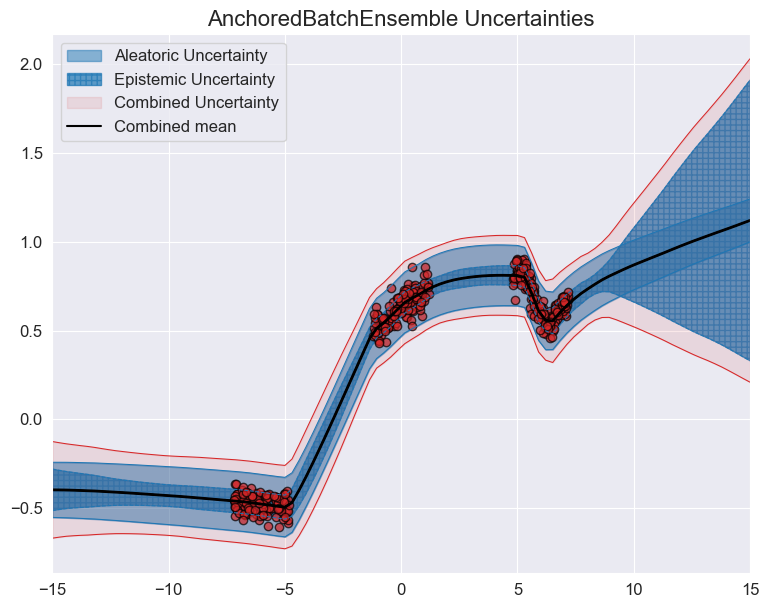

In [45]:
from utils.functions import plot_predictive_2  # Import plotting function

z = np.linspace(-15, 15, 100)  # Create input values

# Convert to tensor, add dimension, and move to device
inp = torch.from_numpy(z.astype(np.float32)).unsqueeze(1).to(device)

# Get model output
out = model(inp.unsqueeze(1).expand(-1,ensemble_size,-1))

# Process output for plotting
means = out[0].squeeze().cpu().detach().numpy().T
variances = out[1].squeeze().cpu().detach().numpy().T

# Plot uncertainties
plot_predictive_2(data, means, variances, ensemble_size=ensemble_size, xs= z, title="AnchoredBatchEnsemble Uncertainties")
